In [1]:
import wfdb
import numpy as np
import pandas as pd
from scipy.fft import fft
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def read_ecg(file_path):
    """
    output: ecg files, get signal, annotated peaks, annotated types
    input: ecg file id
    """
    signals, fields = wfdb.rdsamp(file_path)
    annotation = wfdb.rdann(file_path, 'atr')
    ecg_sig = signals[:,0]
    ecg_type = annotation.symbol
    ecg_peak = annotation.sample
    return ecg_sig, ecg_type, ecg_peak

def plot_ecg(ecg_sig, ecg_type, ecg_peak, title='Fig: Train', npeak=10, len_sig=3000):
    """
    demo plot ecg signal with annotated peaks, annotated types
    """
    _, ax = plt.subplots()
    for i in range(0, npeak):
        ax.annotate(ecg_type[i], xy=(ecg_peak[i], -2))
    ax.plot(ecg_sig[0:len_sig])
    ax.plot(ecg_peak[0:npeak], ecg_sig[ecg_peak[0:npeak]], '*')
    ax.set_title(title)

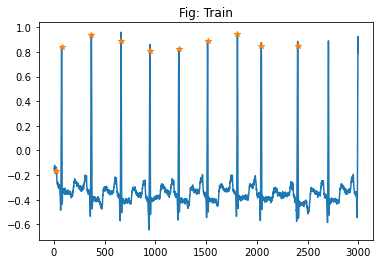

In [3]:
training_file_path = './database/train/100'
ecg_sig, ecg_type, ecg_peak = read_ecg(training_file_path)
plot_ecg(ecg_sig, ecg_type, ecg_peak)

In [4]:
print(len(ecg_sig))
print(len(ecg_type))
print(len(ecg_peak))

650000
2274
2274


In [5]:
feature = []
for idx, data in enumerate(ecg_peak):
    if (idx == 0):
        feature.append(np.abs(np.sum(fft(ecg_sig[0:ecg_peak[idx]]))))
    else:
        feature.append(np.abs(np.sum(fft(ecg_sig[ecg_peak[idx-1]:ecg_peak[idx]]))))

In [6]:
sample_matrix = np.array([feature, ecg_type])
sample_matrix = np.transpose(sample_matrix)

In [7]:
import pandas as pd
df = pd.DataFrame(sample_matrix, columns = ['FFT', 'Target'])

df.tail(70)

,FFT,Target
2204,265.7799999999999,N
2205,269.6699999999999,N
2206,249.93500000000006,N
2207,260.69000000000005,N
2208,291.53999999999985,N
...,...,...
2269,245.00000000000006,N
2270,243.8400000000001,N
2271,229.31999999999996,N
2272,222.5,N


In [8]:
df['Target'].replace(to_replace=['N','A','+','~','V','|','Q','R','"','F'], value =[0,1,1,1,1,1,1,1,1,1], inplace = True)
df.head(10)

,FFT,Target
0,2.61,1
1,10.030000000000012,0
2,246.11999999999998,0
3,274.47999999999996,0
4,251.34000000000006,0
5,230.8500000000001,0
6,232.88,0
7,260.18999999999994,0
8,222.07499999999987,1
9,302.51,0


In [9]:
X = df[['FFT']]
df['Target'] = pd.to_numeric(df['Target'])
y = df['Target']

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 0)
print(X_train)
print(y_train)

                     FFT
1455  287.63999999999993
546   236.69999999999996
979   303.96000000000015
619   211.72000000000003
1840   311.0600000000001
...                  ...
1033  314.92500000000007
1731   263.6250000000001
763   232.96499999999992
835    238.0149999999999
1653  322.05000000000007

[1705 rows x 1 columns]
1455    0
546     0
979     0
619     0
1840    0
       ..
1033    0
1731    0
763     0
835     0
1653    0
Name: Target, Length: 1705, dtype: int64


In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

# SVM

In [13]:
from sklearn.svm import SVC
svm = SVC()

# defining parameter range
svm_parameters = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'degree':[2,3,4],
              'kernel': ['linear', 'rbf','poly', 'sigmoid']}
 
svm_cv = HalvingGridSearchCV(svm, svm_parameters, refit = True, verbose = 3)
 
# fitting the model for grid search
svm_cv.fit(X_train,y_train)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 20
max_resources_: 1705
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 300
n_resources: 20
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV 1/5] END C=0.1, degree=2, gamma=1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=0.1, degree=2, gamma=1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=0.1, degree=2, gamma=1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=0.1, degree=2, gamma=1, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=0.1, degree=2, gamma=1, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=0.1, degree=2,

[CV 1/5] END C=0.1, degree=3, gamma=0.1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=0.1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=0.1, degree=3, gamma=0.1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=0.1, degree=3, gamma=0.1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=0.1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=0.01, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=0.01, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=0.1, degree=3, gamma=0.01, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=0.1, degree=3, gamma=0.01, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=0.01, kernel=linear

[CV 2/5] END C=0.1, degree=4, gamma=0.001, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=0.1, degree=4, gamma=0.001, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=0.1, degree=4, gamma=0.001, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=0.1, degree=4, gamma=0.001, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=0.1, degree=4, gamma=0.001, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=0.1, degree=4, gamma=0.001, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=0.1, degree=4, gamma=0.001, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=0.1, degree=4, gamma=0.001, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=0.1, degree=4, gamma=0.001, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=0.1, degree=4, gamma=0.0001, kerne

[CV 5/5] END C=1, degree=2, gamma=0.0001, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=1, degree=3, gamma=1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=1, degree=3, gamma=1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=1, degree=3, gamma=1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=1, degree=3, gamma=1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=1, degree=3, gamma=1, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=1, degree=3, gamma=1, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=1, degree=3, gamma=1, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=1, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/

[CV 3/5] END C=1, degree=4, gamma=0.1, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=1, degree=4, gamma=0.1, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=1, degree=4, gamma=0.1, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=1, degree=4, gamma=0.1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=1, degree=4, gamma=0.1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=1, degree=4, gamma=0.1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=1, degree=4, gamma=0.1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=1, degree=4, gamma=0.1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=1, degree=4, gamma=0.01, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=1, degree=4, gamma=0.01, kernel=linear;, score=(train=nan, test=nan

[CV 4/5] END C=10, degree=2, gamma=0.001, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.001, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.001, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.001, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.001, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.001, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.001, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.0001, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.0001, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.0001, kernel=li

[CV 4/5] END C=10, degree=4, gamma=1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=10, degree=4, gamma=1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=10, degree=4, gamma=0.1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=10, degree=4, gamma=0.1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=10, degree=4, gamma=0.1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=10, degree=4, gamma=0.1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=10, degree=4, gamma=0.1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=10, degree=4, gamma=0.1, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=10, degree=4, gamma=0.1, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=10, degree=4, gamma=0.1, kernel=rbf;, score=(train=nan, test=nan) 

[CV 3/5] END C=100, degree=2, gamma=0.01, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=0.01, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=0.01, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=0.001, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.001, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=0.001, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=0.001, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=0.001, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=0.001, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.001, kernel

[CV 4/5] END C=100, degree=3, gamma=0.0001, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=100, degree=3, gamma=0.0001, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=100, degree=4, gamma=1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=100, degree=4, gamma=1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=100, degree=4, gamma=1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=100, degree=4, gamma=1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=100, degree=4, gamma=1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=100, degree=4, gamma=1, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=100, degree=4, gamma=1, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=100, degree=4, gamma=1, kernel=rbf;, score=(train=nan, test=n

[CV 2/5] END C=1000, degree=2, gamma=1, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=1000, degree=2, gamma=1, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=1, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=1, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=1000, degree=2, gamma=1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=0.1, kernel=linear;, score=(train=nan, 

[CV 1/5] END C=1000, degree=3, gamma=0.01, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=0.01, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=0.01, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=0.01, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=0.01, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=0.01, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=0.01, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=0.01, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=0.01, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=0.01, kernel=rbf;, sc

[CV 1/5] END C=1000, degree=4, gamma=0.0001, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=1000, degree=4, gamma=0.0001, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=1000, degree=4, gamma=0.0001, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=1000, degree=4, gamma=0.0001, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=1000, degree=4, gamma=0.0001, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=1000, degree=4, gamma=0.0001, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=1000, degree=4, gamma=0.0001, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=1000, degree=4, gamma=0.0001, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=1000, degree=4, gamma=0.0001, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=1000, degree=4, gamma=0.0001, kernel

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1500 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1500 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Acer\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 199, in fit
    y = self._validate_targets(y)
  File "C:\Users\Acer\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 720, in _validate_targets
    raise ValueError(
ValueError: The number of classes has to be greater than

[CV 3/5] END C=0.1, degree=3, gamma=0.1, kernel=linear;, score=(train=0.958, test=1.000) total time=   0.0s
[CV 4/5] END C=0.1, degree=3, gamma=0.1, kernel=linear;, score=(train=0.979, test=1.000) total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=0.1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=1, kernel=sigmoid;, score=(train=0.979, test=1.000) total time=   0.0s
[CV 3/5] END C=0.1, degree=3, gamma=1, kernel=sigmoid;, score=(train=0.958, test=1.000) total time=   0.0s
[CV 4/5] END C=0.1, degree=3, gamma=1, kernel=sigmoid;, score=(train=0.979, test=1.000) total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=1, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=1, kernel=poly;, 

[CV 4/5] END C=1, degree=4, gamma=0.0001, kernel=rbf;, score=(train=0.979, test=1.000) total time=   0.0s
[CV 5/5] END C=1, degree=4, gamma=0.0001, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=1, degree=4, gamma=0.0001, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=1, degree=4, gamma=0.0001, kernel=linear;, score=(train=0.979, test=1.000) total time=   0.0s
[CV 3/5] END C=1, degree=4, gamma=0.0001, kernel=linear;, score=(train=0.958, test=1.000) total time=   0.0s
[CV 4/5] END C=1, degree=4, gamma=0.0001, kernel=linear;, score=(train=0.979, test=1.000) total time=   0.0s
[CV 5/5] END C=1, degree=4, gamma=0.0001, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=1, degree=4, gamma=0.001, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=1, degree=4, gamma=0.001, kernel=sigmoid;, score=(train=0.979, test=1.000) total time=   0.0s
[CV 3/5] END C=1, degree=4, gamma=0.001, 

[CV 1/5] END C=10, degree=2, gamma=0.001, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.001, kernel=poly;, score=(train=0.979, test=1.000) total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.001, kernel=poly;, score=(train=0.958, test=1.000) total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.001, kernel=poly;, score=(train=0.979, test=1.000) total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.001, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.001, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.001, kernel=rbf;, score=(train=0.979, test=1.000) total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.001, kernel=rbf;, score=(train=0.958, test=1.000) total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.001, kernel=rbf;, score=(train=0.979, test=1.000) total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.001, kernel=rbf;

[CV 1/5] END C=1, degree=3, gamma=0.01, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=1, degree=3, gamma=0.01, kernel=sigmoid;, score=(train=0.979, test=1.000) total time=   0.0s
[CV 3/5] END C=1, degree=3, gamma=0.01, kernel=sigmoid;, score=(train=0.958, test=1.000) total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=0.01, kernel=sigmoid;, score=(train=0.979, test=1.000) total time=   0.0s
[CV 5/5] END C=1, degree=3, gamma=0.01, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=1, degree=4, gamma=0.01, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=1, degree=4, gamma=0.01, kernel=sigmoid;, score=(train=0.979, test=1.000) total time=   0.0s
[CV 3/5] END C=1, degree=4, gamma=0.01, kernel=sigmoid;, score=(train=0.958, test=1.000) total time=   0.0s
[CV 4/5] END C=1, degree=4, gamma=0.01, kernel=sigmoid;, score=(train=0.979, test=1.000) total time=   0.0s
[CV 5/5] END C=1, degree=4, gamma=0.01, 

[CV 1/5] END C=1, degree=3, gamma=0.001, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=1, degree=3, gamma=0.001, kernel=rbf;, score=(train=0.979, test=1.000) total time=   0.0s
[CV 3/5] END C=1, degree=3, gamma=0.001, kernel=rbf;, score=(train=0.958, test=1.000) total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=0.001, kernel=rbf;, score=(train=0.979, test=1.000) total time=   0.0s
[CV 5/5] END C=1, degree=3, gamma=0.001, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=1000, degree=4, gamma=0.0001, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=1000, degree=4, gamma=0.0001, kernel=sigmoid;, score=(train=0.979, test=1.000) total time=   0.0s
[CV 3/5] END C=1000, degree=4, gamma=0.0001, kernel=sigmoid;, score=(train=0.958, test=1.000) total time=   0.0s
[CV 4/5] END C=1000, degree=4, gamma=0.0001, kernel=sigmoid;, score=(train=0.979, test=1.000) total time=   0.0s
[CV 5/5] END C=1000, degree=4, gamm

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
200 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Acer\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 199, in fit
    y = self._validate_targets(y)
  File "C:\Users\Acer\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 720, in _validate_targets
    raise ValueError(
ValueError: The number of classes has to be greater than on

[CV 5/5] END C=10, degree=2, gamma=0.001, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.01, kernel=poly;, score=(train=0.979, test=0.972) total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.01, kernel=poly;, score=(train=0.979, test=0.972) total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.01, kernel=poly;, score=(train=0.979, test=0.972) total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.01, kernel=poly;, score=(train=0.951, test=1.000) total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.01, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=1, degree=4, gamma=0.001, kernel=rbf;, score=(train=0.979, test=0.972) total time=   0.0s
[CV 2/5] END C=1, degree=4, gamma=0.001, kernel=rbf;, score=(train=0.979, test=0.972) total time=   0.0s
[CV 3/5] END C=1, degree=4, gamma=0.001, kernel=rbf;, score=(train=0.979, test=0.972) total time=   0.0s
[CV 4/5] END C=1, degree=4, gamma=0.001, kernel=rbf;, 

[CV 4/5] END C=10, degree=2, gamma=0.1, kernel=poly;, score=(train=0.951, test=1.000) total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.1, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.1, kernel=sigmoid;, score=(train=0.979, test=0.972) total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.1, kernel=sigmoid;, score=(train=0.979, test=0.972) total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.1, kernel=sigmoid;, score=(train=0.979, test=0.972) total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.1, kernel=sigmoid;, score=(train=0.951, test=1.000) total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.01, kernel=linear;, score=(train=0.979, test=0.972) total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.01, kernel=linear;, score=(train=0.986, test=0.972) total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.01, k

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
34 fits failed out of a total of 170.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
34 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Acer\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 199, in fit
    y = self._validate_targets(y)
  File "C:\Users\Acer\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 720, in _validate_targets
    raise ValueError(
ValueError: The number of classes has to be greater than one;

[CV 4/5] END C=10, degree=3, gamma=0.1, kernel=sigmoid;, score=(train=0.984, test=0.981) total time=   0.0s
[CV 5/5] END C=10, degree=3, gamma=0.1, kernel=sigmoid;, score=(train=0.981, test=0.981) total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.001, kernel=linear;, score=(train=0.998, test=0.981) total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.001, kernel=linear;, score=(train=0.981, test=0.981) total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.001, kernel=linear;, score=(train=0.991, test=0.972) total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.001, kernel=linear;, score=(train=0.988, test=0.972) total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.001, kernel=linear;, score=(train=0.984, test=0.991) total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.01, kernel=poly;, score=(train=0.995, test=0.981) total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.01, kernel=poly;, score=(train=0.981, test=0.981) total time=   0.0s
[CV 3/5] END C=10, degree=2

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        na

[CV 3/5] END C=1, degree=2, gamma=0.001, kernel=poly;, score=(train=0.984, test=0.981) total time=   0.0s
[CV 4/5] END C=1, degree=2, gamma=0.001, kernel=poly;, score=(train=0.984, test=0.981) total time=   0.0s
[CV 5/5] END C=1, degree=2, gamma=0.001, kernel=poly;, score=(train=0.983, test=0.981) total time=   0.0s
[CV 1/5] END C=1000, degree=4, gamma=0.0001, kernel=sigmoid;, score=(train=0.983, test=0.985) total time=   0.0s
[CV 2/5] END C=1000, degree=4, gamma=0.0001, kernel=sigmoid;, score=(train=0.984, test=0.985) total time=   0.0s
[CV 3/5] END C=1000, degree=4, gamma=0.0001, kernel=sigmoid;, score=(train=0.984, test=0.981) total time=   0.0s
[CV 4/5] END C=1000, degree=4, gamma=0.0001, kernel=sigmoid;, score=(train=0.984, test=0.981) total time=   0.0s
[CV 5/5] END C=1000, degree=4, gamma=0.0001, kernel=sigmoid;, score=(train=0.983, test=0.981) total time=   0.0s


HalvingGridSearchCV(estimator=SVC(),
                    param_grid={'C': [0.1, 1, 10, 100, 1000],
                                'degree': [2, 3, 4],
                                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
                    verbose=3)

In [14]:
# print best parameter after tuning
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
 
# print how our model looks after hyper-parameter tuning
print("tuned hpyerparameters :(best estimators) ",svm_cv.best_estimator_)

tuned hpyerparameters :(best parameters)  {'C': 10, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}
tuned hpyerparameters :(best estimators)  SVC(C=10, gamma=0.1, kernel='poly')


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
svm_predictions = svm_cv.predict(X_val)
 
# print classification report
print(classification_report(y_val, svm_predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       562
           1       0.00      0.00      0.00         7

    accuracy                           0.99       569
   macro avg       0.49      0.50      0.50       569
weighted avg       0.98      0.99      0.98       569



# Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
# defining parameter range
logreg_parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

lr=LogisticRegression()

logreg_cv = HalvingGridSearchCV(lr, logreg_parameters, refit = True, verbose = 3)
 
# fitting the model for grid search
logreg_cv.fit(X_train,y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 568
max_resources_: 1705
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 568
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END C=0.01, penalty=l2, solver=lbfgs;, score=(train=0.989, test=0.982) total time=   0.0s
[CV 2/5] END C=0.01, penalty=l2, solver=lbfgs;, score=(train=0.989, test=0.991) total time=   0.0s
[CV 3/5] END C=0.01, penalty=l2, solver=lbfgs;, score=(train=0.985, test=0.982) total time=   0.0s
[CV 4/5] END C=0.01, penalty=l2, solver=lbfgs;, score=(train=0.985, test=0.991) total time=   0.0s
[CV 5/5] END C=0.01, penalty=l2, solver=lbfgs;, score=(train=0.978, test=0.991) total time=   0.0s
[CV 1/5] END C=0.1, penalty=l2, solver=lbfgs;, score=(train=0.989, test=0.982) total time=   0.0s
[CV 2/5] END C=0.1, penalty=l2, solver=lbfgs;, score=(train=0.989, test=0.991) total time=   0.0s
[CV 3/5] END C=0.1, penalty=l2, solver=lbfgs;, sco

HalvingGridSearchCV(estimator=LogisticRegression(),
                    param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                                'solver': ['lbfgs']},
                    verbose=3)

In [17]:
# print best parameter after tuning
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
 
# print how our model looks after hyper-parameter tuning
print("tuned hpyerparameters :(best estimators) ",logreg_cv.best_estimator_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
tuned hpyerparameters :(best estimators)  LogisticRegression(C=1)


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
logreg_predictions = logreg_cv.predict(X_val)
 
# print classification report
print(classification_report(y_val, logreg_predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       562
           1       0.00      0.00      0.00         7

    accuracy                           0.99       569
   macro avg       0.49      0.50      0.50       569
weighted avg       0.98      0.99      0.98       569



# KNN

In [19]:
from sklearn.neighbors import KNeighborsClassifier
knn_parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

knn = KNeighborsClassifier()

knn_cv = HalvingGridSearchCV(knn, knn_parameters, refit = True, verbose = 3)
 
# fitting the model for grid search
knn_cv.fit(X_train,y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 63
max_resources_: 1705
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 80
n_resources: 63
Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END algorithm=auto, n_neighbors=1, p=1;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=1, p=1;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=1, p=1;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=1, p=1;, score=(train=1.000, test=0.917) total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=1, p=1;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=1, p=2;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=1, p=2;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 3/5] END algorithm=auto, n_ne

[CV 3/5] END algorithm=ball_tree, n_neighbors=2, p=1;, score=(train=0.980, test=1.000) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, n_neighbors=2, p=1;, score=(train=0.980, test=0.917) total time=   0.0s
[CV 5/5] END algorithm=ball_tree, n_neighbors=2, p=1;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 1/5] END algorithm=ball_tree, n_neighbors=2, p=2;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, n_neighbors=2, p=2;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 3/5] END algorithm=ball_tree, n_neighbors=2, p=2;, score=(train=0.980, test=1.000) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, n_neighbors=2, p=2;, score=(train=0.980, test=0.917) total time=   0.0s
[CV 5/5] END algorithm=ball_tree, n_neighbors=2, p=2;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 1/5] END algorithm=ball_tree, n_neighbors=3, p=1;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, n_neighbors=

[CV 5/5] END algorithm=kd_tree, n_neighbors=3, p=1;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 1/5] END algorithm=kd_tree, n_neighbors=3, p=2;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 2/5] END algorithm=kd_tree, n_neighbors=3, p=2;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 3/5] END algorithm=kd_tree, n_neighbors=3, p=2;, score=(train=0.980, test=1.000) total time=   0.0s
[CV 4/5] END algorithm=kd_tree, n_neighbors=3, p=2;, score=(train=0.980, test=0.917) total time=   0.0s
[CV 5/5] END algorithm=kd_tree, n_neighbors=3, p=2;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 1/5] END algorithm=kd_tree, n_neighbors=4, p=1;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 2/5] END algorithm=kd_tree, n_neighbors=4, p=1;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 3/5] END algorithm=kd_tree, n_neighbors=4, p=1;, score=(train=0.980, test=1.000) total time=   0.0s
[CV 4/5] END algorithm=kd_tree, n_neighbors=4, p=1;, score=(trai

[CV 2/5] END algorithm=brute, n_neighbors=3, p=1;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 3/5] END algorithm=brute, n_neighbors=3, p=1;, score=(train=0.980, test=1.000) total time=   0.0s
[CV 4/5] END algorithm=brute, n_neighbors=3, p=1;, score=(train=0.980, test=0.917) total time=   0.0s
[CV 5/5] END algorithm=brute, n_neighbors=3, p=1;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 1/5] END algorithm=brute, n_neighbors=3, p=2;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 2/5] END algorithm=brute, n_neighbors=3, p=2;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 3/5] END algorithm=brute, n_neighbors=3, p=2;, score=(train=0.980, test=1.000) total time=   0.0s
[CV 4/5] END algorithm=brute, n_neighbors=3, p=2;, score=(train=0.980, test=0.917) total time=   0.0s
[CV 5/5] END algorithm=brute, n_neighbors=3, p=2;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 1/5] END algorithm=brute, n_neighbors=4, p=1;, score=(train=1.000, test=1.000)

[CV 3/5] END algorithm=auto, n_neighbors=1, p=2;, score=(train=1.000, test=0.946) total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=1, p=2;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=1, p=2;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=5, p=1;, score=(train=0.993, test=1.000) total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=5, p=1;, score=(train=0.980, test=1.000) total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=5, p=1;, score=(train=0.974, test=0.973) total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=5, p=1;, score=(train=0.993, test=1.000) total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=5, p=1;, score=(train=0.980, test=1.000) total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=10, p=1;, score=(train=0.993, test=1.000) total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=10, p=1;, score=(train=0.980, test=1.000) total t

[CV 1/5] END algorithm=ball_tree, n_neighbors=3, p=1;, score=(train=0.993, test=1.000) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, n_neighbors=3, p=1;, score=(train=0.980, test=1.000) total time=   0.0s
[CV 3/5] END algorithm=ball_tree, n_neighbors=3, p=1;, score=(train=0.974, test=0.973) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, n_neighbors=3, p=1;, score=(train=0.993, test=1.000) total time=   0.0s
[CV 5/5] END algorithm=ball_tree, n_neighbors=3, p=1;, score=(train=0.980, test=1.000) total time=   0.0s
[CV 1/5] END algorithm=ball_tree, n_neighbors=2, p=2;, score=(train=0.993, test=1.000) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, n_neighbors=2, p=2;, score=(train=0.980, test=1.000) total time=   0.0s
[CV 3/5] END algorithm=ball_tree, n_neighbors=2, p=2;, score=(train=0.974, test=0.973) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, n_neighbors=2, p=2;, score=(train=0.993, test=1.000) total time=   0.0s
[CV 5/5] END algorithm=ball_tree, n_neighbors=

[CV 4/5] END algorithm=auto, n_neighbors=5, p=1;, score=(train=0.986, test=0.974) total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=5, p=1;, score=(train=0.987, test=0.982) total time=   0.0s
[CV 1/5] END algorithm=brute, n_neighbors=10, p=1;, score=(train=0.983, test=0.985) total time=   0.0s
[CV 2/5] END algorithm=brute, n_neighbors=10, p=1;, score=(train=0.983, test=0.985) total time=   0.0s
[CV 3/5] END algorithm=brute, n_neighbors=10, p=1;, score=(train=0.985, test=0.982) total time=   0.0s
[CV 4/5] END algorithm=brute, n_neighbors=10, p=1;, score=(train=0.988, test=0.976) total time=   0.0s
[CV 5/5] END algorithm=brute, n_neighbors=10, p=1;, score=(train=0.985, test=0.982) total time=   0.0s
[CV 1/5] END algorithm=brute, n_neighbors=10, p=2;, score=(train=0.983, test=0.985) total time=   0.0s
[CV 2/5] END algorithm=brute, n_neighbors=10, p=2;, score=(train=0.983, test=0.985) total time=   0.0s
[CV 3/5] END algorithm=brute, n_neighbors=10, p=2;, score=(train=0.985, test=

HalvingGridSearchCV(estimator=KNeighborsClassifier(),
                    param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree',
                                              'brute'],
                                'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                'p': [1, 2]},
                    verbose=3)

In [20]:
# print best parameter after tuning
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
 
# print how our model looks after hyper-parameter tuning
print("tuned hpyerparameters :(best estimators) ",knn_cv.best_estimator_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'brute', 'n_neighbors': 10, 'p': 1}
tuned hpyerparameters :(best estimators)  KNeighborsClassifier(algorithm='brute', n_neighbors=10, p=1)


In [21]:
from sklearn.metrics import classification_report, confusion_matrix
knn_predictions = knn_cv.predict(X_val)
 
# print classification report
print(classification_report(y_val, knn_predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       562
           1       0.00      0.00      0.00         7

    accuracy                           0.99       569
   macro avg       0.49      0.50      0.50       569
weighted avg       0.98      0.99      0.98       569



# Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier
rf_parameters = {'n_estimators': [100, 200, 400, 800, 1000],
              'criterion': ['gini', 'entropy']}

rf = RandomForestClassifier()

rf_cv = HalvingGridSearchCV(rf, rf_parameters, refit = True, verbose = 3)
 
# fitting the model for grid search
rf_cv.fit(X_train,y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 189
max_resources_: 1705
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 189
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END criterion=gini, n_estimators=100;, score=(train=1.000, test=0.973) total time=   0.0s
[CV 2/5] END criterion=gini, n_estimators=100;, score=(train=1.000, test=0.946) total time=   0.0s
[CV 3/5] END criterion=gini, n_estimators=100;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END criterion=gini, n_estimators=100;, score=(train=1.000, test=0.946) total time=   0.1s
[CV 5/5] END criterion=gini, n_estimators=100;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 1/5] END criterion=gini, n_estimators=200;, score=(train=1.000, test=0.973) total time=   0.2s
[CV 2/5] END criterion=gini, n_estimators=200;, score=(train=1.000, test=0.946) total time=   0.1s
[CV 3/5] END criterion=gini, n_estimators=200;

[CV 3/5] END criterion=entropy, n_estimators=1000;, score=(train=0.999, test=0.979) total time=   2.0s
[CV 4/5] END criterion=entropy, n_estimators=1000;, score=(train=0.998, test=0.959) total time=   1.9s
[CV 5/5] END criterion=entropy, n_estimators=1000;, score=(train=0.998, test=0.976) total time=   2.1s


HalvingGridSearchCV(estimator=RandomForestClassifier(),
                    param_grid={'criterion': ['gini', 'entropy'],
                                'n_estimators': [100, 200, 400, 800, 1000]},
                    verbose=3)

In [23]:
# print best parameter after tuning
print("tuned hpyerparameters :(best parameters) ",rf_cv.best_params_)
 
# print how our model looks after hyper-parameter tuning
print("tuned hpyerparameters :(best estimators) ",rf_cv.best_estimator_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'n_estimators': 800}
tuned hpyerparameters :(best estimators)  RandomForestClassifier(criterion='entropy', n_estimators=800)


In [24]:
from sklearn.metrics import classification_report, confusion_matrix
rf_predictions = rf_cv.predict(X_val)
 
# print classification report
print(classification_report(y_val, rf_predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       562
           1       0.00      0.00      0.00         7

    accuracy                           0.98       569
   macro avg       0.49      0.50      0.50       569
weighted avg       0.98      0.98      0.98       569



In [25]:
# Creating a function to report confusion metrics
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    #print('True Positives:', TP)
    #print('True Negatives:', TN)
    #print('False Positives:', FP)
    #print('False Negatives:', FN)
    #print(" ")
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TP / float(TP + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    #print('-'*50)
    #print(f'Accuracy: {round(conf_accuracy,2)}') 
    #print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    #print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    #print(f'Specificity: {round(conf_specificity,2)}') 
    #print(f'Precision: {round(conf_precision,2)}')
    #print(f'f_1 Score: {round(conf_f1,2)}')
    return TP, TN, FP, FN, conf_accuracy, conf_misclassification, conf_sensitivity, conf_specificity, conf_precision, conf_f1

In [26]:
cm_svm = confusion_matrix(y_val, svm_predictions)
svm_cm = confusion_metrics(cm_svm)
svm_cm

C:\Users\Acer\AppData\Local\Temp/ipykernel_23080/3172376750.py:28: RuntimeWarning: invalid value encountered in double_scalars
  conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))


(0,
 561,
 1,
 7,
 0.9859402460456942,
 0.01405975395430581,
 0.0,
 0.998220640569395,
 0.0,
 nan)

In [27]:
cm_svm = confusion_matrix(y_val, svm_predictions)
svm_cm = confusion_metrics(cm_svm)
acc_svm = round(svm_cm[4],4)*100
sen_svm = round(svm_cm[6],4)*100
spec_svm = round(svm_cm[7],4)*100
pre_svm = round(svm_cm[8],4)*100
f1_svm = round(svm_cm[9],4)*100

cm_knn = confusion_matrix(y_val, knn_predictions)
knn_cm = confusion_metrics(cm_knn)
acc_knn = round(knn_cm [4],4)*100
sen_knn = round(knn_cm [6],4)*100
spec_knn = round(knn_cm [7],4)*100
pre_knn = round(knn_cm [8],4)*100
f1_knn = round(knn_cm[9],4)*100

cm_rf = confusion_matrix(y_val, rf_predictions)
rf_cm = confusion_metrics(cm_rf)
acc_rf = round(rf_cm [4],4)*100
sen_rf = round(rf_cm[6],4)*100
spec_rf = round(rf_cm [7],4)*100
pre_rf = round(rf_cm [8],4)*100
f1_rf = round(rf_cm[9],4)*100

cm_lr = confusion_matrix(y_val, logreg_predictions)
lr_cm = confusion_metrics(cm_lr)
acc_lr = round(lr_cm[4],4)*100
sen_lr = round(lr_cm[6],4)*100
spec_lr = round(lr_cm[7],4)*100
pre_lr = round(lr_cm[8],4)*100
f1_lr = round(lr_cm[9],4)*100

cm_svm = confusion_matrix(y_val, svm_predictions)
Accuracy = [acc_svm, acc_knn, acc_rf, acc_lr]
Sensitivity = [sen_svm, sen_knn, sen_rf, sen_lr]
Specificity = [spec_svm, spec_knn, spec_rf, spec_lr]
Precision = [pre_svm, pre_knn, pre_rf, pre_lr]
F1 = [f1_svm, f1_knn, f1_rf, f1_lr]

df_score = {'Algorithm': ['SVM', 'K-NN', 'Randon Forest', 'Logistic Regression'], 'Accuracy': Accuracy, 'Sensitivity':Sensitivity, 'Specificity':Specificity, 'Precision':Precision, 'F1-score':F1}
Perform_measure = pd.DataFrame(data = df_score, columns = ['Algorithm', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1-score'], index = None)
Perform_measure

C:\Users\Acer\AppData\Local\Temp/ipykernel_23080/3172376750.py:28: RuntimeWarning: invalid value encountered in double_scalars
  conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
C:\Users\Acer\AppData\Local\Temp/ipykernel_23080/3172376750.py:28: RuntimeWarning: invalid value encountered in double_scalars
  conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
C:\Users\Acer\AppData\Local\Temp/ipykernel_23080/3172376750.py:28: RuntimeWarning: invalid value encountered in double_scalars
  conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
C:\Users\Acer\AppData\Local\Temp/ipykernel_23080/3172376750.py:28: RuntimeWarning: invalid value encountered in double_scalars
  conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))


,Algorithm,Accuracy,Sensitivity,Specificity,Precision,F1-score
0,SVM,98.59,0.0,99.82,0.0,NaN
1,K-NN,98.59,0.0,99.82,0.0,NaN
2,Randon Forest,98.07,0.0,99.29,0.0,NaN
3,Logistic Regression,98.59,0.0,99.82,0.0,NaN
